<a href="https://colab.research.google.com/github/JWuzyk/ML-Lab-Facial-Keypoint-Detection/blob/master/Machine_Learning_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tasks:
  - Preprocessing ()
  - Data Augmentation (partially done) see https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html (Reflection, Rotation, Contrast Jittering?)
  - Different Models for each keypoint
  - Transfer Learning (partially done) - Could add more refinement in the imported network, see keras documentation, need to retrain some of layers in the network, consider using other networks, potentially one pretrained on faces not ImageNet ,eg. VGGFace https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
  - Find More Data e.g. http://www.milbo.org/muct/,https://github.com/soheillll/Facial-Keypoint-Detection,https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints, http://umdfaces.io/
  - Hyperparameter Tuning with Tensorboard + saving models see https://www.youtube.com/watch?v=BqgTU7_cBnk (learing rate, optimiser )
  - Do a proper validartion split
  - Set up Kaggle submission
  - Use an emsemble model


Stretch Goals
  - Combine with face detection and apply to other images
  
Challenge:
  - Lots of the data is missing values so we can't train on all of it and there is no sensible way to fill in missing data
  
Solution: 
  - Train individual models for each feature
  
Resources:
  -http://cs231n.stanford.edu/reports/2016/pdfs/010_Report.pdf ; basically a paper by someone doing exactly what we are doing

## Load data



In [0]:
# Load from github

!git clone https://github.com/JWuzyk/ML-Lab-Facial-Keypoint-Detection/
%cd ML-Lab-Facial-Keypoint-Detection/ 

!unzip data/test.zip 
!unzip data/training.zip

!ls

Cloning into 'ML-Lab-Facial-Keypoint-Detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 1), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
/content/ML-Lab-Facial-Keypoint-Detection
Archive:  data/test.zip
  inflating: test.csv                
Archive:  data/training.zip
  inflating: training.csv            
data  Machine_Learning_Lab_Project.ipynb  README.md  test.csv  training.csv


In [57]:
#Reading in the data from my drive as pandas Dataframes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IDLookupTable = pd.read_csv('data/IdLookupTable.csv')
Training = pd.read_csv('training.csv')
Test = pd.read_csv('test.csv')
print(Training.shape)

# For now I am just naively dropping all data with missing data. We should deifnitely do something more sophisticates as discussed.

Training = Training.dropna()
Training = Training.reset_index(drop=True)
print(Training.shape)


(7049, 31)
(2140, 31)


In [0]:
#separate data into columns

left_eye_center = df.iloc[:,0:2]
right_eye_center = df.iloc[:,2:4]
left_eye_inner_corner = df.iloc[:,4:6]
left_eye_outer_corner = df.iloc[:,6:8]
right_eye_inner_corner = df.iloc[:,8:10]
right_eye_outer_corner = df.iloc[:,10:12]

left_eyebrow_inner_end = df.iloc[:,12:14]
left_eyebrow_outer_end = df.iloc[:,14:16]
right_eyebrow_inner_end = df.iloc[:,16:18]
right_eyebrow_outer_end = df.iloc[:,18:20]

nose_tip = df.iloc[:,20:22]

mouth_left_corner = df.iloc[:,22:24]
mouth_right_corner = df.iloc[:,24:26]
mouth_center_top_lip = df.iloc[:,26:28]
mouth_center_bottom_lip = df.iloc[:,28:30]
image = df.iloc[:,30]

Hi Libby

Hello!

How's it going?

Pretty good...maybe we don't need whatsapp anymore

Seems so

In [0]:
#Turning the data from a dataframe into x_train,y_train, x_test numpy arrays so that we can use it
# x_train has shape (2140,96,96,3) 2140 images each 96x96 with 3 colour channels, y_train has shape (2140,30), in the form (x_1,y_1,...x_15,y_15) for the 15 keypoints

# Copied the getimage method from https://github.com/shichaoji/img_extract/blob/master/img_extract.py, definitely is a faster way for reading in data but it's nice for viewing the images

from PIL import Image

# Takes a string representing a 96x96 image as in the last column of the training.csv and returns a PIL image
def getimage(each):
    img = Image.new( 'RGB', (96,96), "black") 
    pixels = img.load() # create the pixel map
    
    cot=[int(i) for i in each.split(' ')]
    for i in range(img.size[0]):    # for every pixel:
        for j in range(img.size[1]):
            pixels[i,j] = (cot[i+j*96],cot[i+j*96],cot[i+j*96]) # set the colour accordingly
    return img

  
  
n_rows = Training.shape[0]

# turn Training into numpy arrays
x_train=np.zeros((n_rows,96,96,3))

for i in range(n_rows):
  im = np.array(getimage(Training['Image'][i]))
  x_train[i] = im


y_train = np.zeros((n_rows,30))

for i in range(n_rows):
  y_train[i] = np.array(Training.iloc[i,:-1])
  


# turn Test into numpy arrays

n_rows = Test.shape[0]

x_test=np.zeros((n_rows,96,96,3))

for i in range(n_rows):
  im = np.array(getimage(Test['Image'][i]))
  x_test[i] = im




In [59]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

# Data Augmentation 

images = (x_train).astype(np.uint8)
keys= y_train
#ia.imshow(image)

keys = keys.reshape(keys.shape[0],15,2)

keypoints =[]
for k in range(x_train.shape[0]):
  kps = KeypointsOnImage([Keypoint(*keys[k,i,:]) for i in range(15)], shape=image.shape)
  keypoints.append(kps)
  

seq = iaa.Sequential([
    iaa.Affine(rotate=10,)
])

image_aug, kps_aug = seq(images=images, keypoints=keypoints)
print(image_aug.shape)


# image with keypoints before/after augmentation (shown below)
#image_before = keypoints[30].draw_on_image(images[30], size=2)
#image_after = kps_aug[30].draw_on_image(image_aug[30], size=2)
#ia.imshow(image_before)
#ia.imshow(image_after)

keys_aug = np.array([keypoints[i].to_xy_array() for i in range(len(keypoints))]).reshape(len(keypoints),30)


# add augmented data to training data
x_train = np.concatenate((x_train,image_aug))
y_train = np.concatenate((y_train,keys_aug))

(2140, 96, 96, 3)


In [0]:
# normalize

x_train = x_train/255 

# Plotting functions

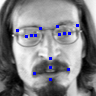

In [0]:

from PIL import ImageDraw

def plotWithKeypoints1(data):

  key = np.array(data.iloc[:-1])
  key = key.astype(int).reshape(15,2)
  
  im = getimage(data['Image'])
  
  draw = ImageDraw.Draw(im)
  for x,y in zip(key[:,0],key[:,1]):
    draw.ellipse((x-1, y-1, x+1, y+1),fill = 'blue')
  return im

def plotWithKeypoints2(im,key):
  
  key = key.astype(int).reshape(15,2)
  img = getimage(im)
  draw = ImageDraw.Draw(img)
  for x,y in zip(key[:,0],key[:,1]):
    draw.ellipse((x-1, y-1, x+1, y+1),fill = 'blue')
  
  return img

plotWithKeypoints1(Training.iloc[100,:])

# Create and Train model

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.models import Model
from keras import backend as K

# Transfer learning based on https://keras.io/applications/


def make_model_transfer():
  # Create a model based on transfer learning from one of the built in keras models, note this section uses the funtional API not Sequential model
  # Xception is a cool model see https://www.youtube.com/watch?v=KfV8CJh7hE0
  # Should replace Xception with VGG Face or at the very least retrain some of it
  
  #importing the base model, should double check that the input is fine
  base_model = Xception(weights='imagenet', include_top=False)
  x = base_model.output
  
  # add a Global Average Pooling for some reason
  x = GlobalAveragePooling2D()(x)
  
  # add a dense layer
  x = Dense(1024, activation='relu')(x)
  
  # a dense layer to compute the predicted keypoints
  coords = Dense(30, activation='linear')(x)
  model = Model(inputs=base_model.input, outputs=coords)
  
  for layer in base_model.layers:
    layer.trainable = False
  return model


# normal learning

def make_model_custom():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(30))
  model.add(Activation('linear'))
  return model

modelC =  make_model_custom()
modelC.compile(optimizer = 'adam',loss='mean_squared_error' )
modelC.fit(x_train,y_train, batch_size=32, epochs=100, validation_split = 0.1)

#modelT =  make_model_transfer()
#modelT.compile(optimizer = 'adam',loss='mean_squared_error')
#modelT.fit(x_train,y_train, batch_size=32, epochs=100, validation_split = 0.1)


# I'm note sure how but it would be nice to have an accuracy metric that meausures being 'near enough' eg in a 5 pixel box

# remember to activate the GPU before training (edit -> notebook settings), runs really quick for me ~2 per epoch, loss went down to 20ish but stayed there
# Tried Transfer learning, error went way down to 3ish, I suspect this is overfitting though, can't quite quantify this yet
#val_acc = model.history.history['val_acc']
#plt.plot(val_acc)

Using TensorFlow backend.
W0707 11:10:24.242220 140667721799552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 11:10:24.277095 140667721799552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 11:10:24.286623 140667721799552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 11:10:24.335923 140667721799552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0707 11:10:24.339880 1406677

Train on 3852 samples, validate on 428 samples
Epoch 1/100
3852/3852 [==============================] - 16s 4ms/step - loss: 222.4942 - val_loss: 233.4960
Epoch 2/100
3852/3852 [==============================] - 9s 2ms/step - loss: 55.1938 - val_loss: 312.6795
Epoch 3/100
3852/3852 [==============================] - 9s 2ms/step - loss: 42.2509 - val_loss: 164.0404
Epoch 4/100
3852/3852 [==============================] - 9s 2ms/step - loss: 34.5701 - val_loss: 124.9831
Epoch 5/100
3852/3852 [==============================] - 9s 2ms/step - loss: 31.8416 - val_loss: 68.5816
Epoch 6/100
3852/3852 [==============================] - 9s 2ms/step - loss: 29.8826 - val_loss: 55.3997
Epoch 7/100
3852/3852 [==============================] - 9s 2ms/step - loss: 27.5442 - val_loss: 46.0579
Epoch 8/100
3852/3852 [==============================] - 9s 2ms/step - loss: 25.6936 - val_loss: 26.5729
Epoch 9/100
3852/3852 [==============================] - 9s 2ms/step - loss: 25.7499 - val_loss: 38.8934
Ep

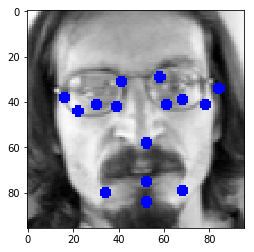

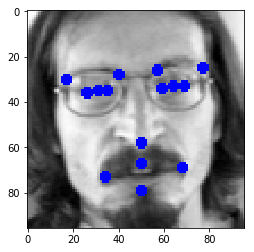

In [0]:
# This already looks like it has the right idea but not yet perfect for me 
keys = modelT.predict(x_train[100].reshape(1,96,96,3))
plt.imshow(plotWithKeypoints2(Training['Image'][100],keys))
plt.show()
plt.imshow(plotWithKeypoints1(Training.iloc[100,:]))
plt.show()

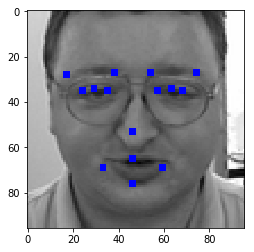

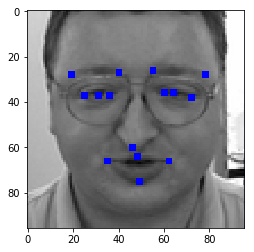

In [64]:
keys = modelC.predict(x_train[50].reshape(1,96,96,3))
plt.imshow(plotWithKeypoints2(Training['Image'][50],keys))
plt.show()
plt.imshow(plotWithKeypoints1(Training.iloc[50,:]))
plt.show()

In [0]:
for i, layer in enumerate(modelT.layers):
   print(i, layer.name)

0 input_5
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_25
13 block2_pool
14 batch_normalization_17
15 add_49
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_26
23 block3_pool
24 batch_normalization_18
25 add_50
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_27
33 block4_pool
34 batch_normalization_19
35 add_51
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_52
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

(50, 96, 96, 3)
[KeypointsOnImage([Keypoint(x=67.22760997, y=42.34969233), Keypoint(x=32.41315315, y=33.59055749), Keypoint(x=60.76210885, y=41.86475174), Keypoint(x=74.04853685, y=44.53505832), Keypoint(x=38.28155210, y=35.60796710), Keypoint(x=25.57388842, y=33.36726313), Keypoint(x=60.01629449, y=30.95573470), Keypoint(x=82.38185949, y=38.14315785), Keypoint(x=43.55017991, y=28.02050488), Keypoint(x=19.92957936, y=24.51065740), Keypoint(x=42.80609593, y=56.38672440), Keypoint(x=55.34886049, y=81.85503963), Keypoint(x=23.71124042, y=73.65547804), Keypoint(x=38.95939850, y=71.82189974), Keypoint(x=36.77457440, y=83.16515440)], shape=(96, 96, 3)), KeypointsOnImage([Keypoint(x=66.25300718, y=38.08344440), Keypoint(x=32.65589090, y=30.61453455), Keypoint(x=60.80660688, y=37.43206266), Keypoint(x=72.33437284, y=40.39161556), Keypoint(x=38.49037980, y=32.57020910), Keypoint(x=27.31516681, y=29.36385522), Keypoint(x=57.22706697, y=29.69453186), Keypoint(x=81.12957278, y=36.07202120), Keypoi

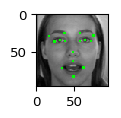

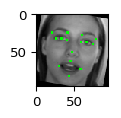

In [0]:
# Test Augmentation 

images = (x_train[0:50]*255).astype(np.uint8)
keys= y_train[0:50]
#ia.imshow(image)

keys = keys.reshape(keys.shape[0],15,2)

keypoints =[]
for k in range(50):
  kps = KeypointsOnImage([Keypoint(*keys[k,i,:]) for i in range(15)], shape=image.shape)
  keypoints.append(kps)
  

seq = iaa.Sequential([
    iaa.Affine(rotate=10,)
])

image_aug, kps_aug = seq(images=images, keypoints=keypoints)
print(image_aug.shape)
print(kps_aug)


# image with keypoints before/after augmentation (shown below)
image_before = keypoints[30].draw_on_image(images[30], size=2)
image_after = kps_aug[30].draw_on_image(image_aug[30], size=2)
ia.imshow(image_before)
ia.imshow(image_after)